# Autocorrélation spatiale
Reproduction avec R l'essentiel d'une analyse menée avec Geoda.

-/-/- - Author: Abdoulaye DIALLO  
-/-/- - École: ENSAI  
-/-/- - Cours: Spatial Data  

#### Sources et Références
[Geospatial Data Analysis | SciPy 2018 | Serge Rey](https://www.youtube.com/watch?v=kJXUUO5M4ok)  

[Spatial Weights](http://darribas.org/gds_scipy16/ipynb_md/03_spatial_weights.html)

[Exploratory Spatial Data Analysis (ESDA)](http://darribas.org/gds_scipy16/ipynb_md/04_esda.html)

[Visualizing Moran's I by ESDA PySAL](http://pysal.org/notebooks/viz/splot/esda_morans_viz.html)  

----------------------------

La première loi de la géographie de **Waldo Tober**: `tout est lié à tout le reste, mais les choses proches sont plus liées que les choses lointaine`.

----------------------------

In [85]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import libpysal as lp

import seaborn as sns

## 1. Les donnnées

#### chargement des données non spatial

In [4]:
# Chargeons les données non spatial à fusionée avec les données spati
medianhousing = gpd.read_file("medianhousing/medianhousing.shp")
print(medianhousing.crs)

epsg:3857


In [5]:
medianhousing.head(2)

,POLY_ID,GEO_ID,STATE,COUNTY,TRACT,NAME,LSAD,SHAPE_AREA,SHAPE_LEN,Id,Id2,Geography,Median_val,Median_v_1,geometry
0,1,1400000US25017300100,25,017,300100,3001,Tract,1.153484e+08,48105.939998,1400000US25017300100,2.501730e+10,"Census Tract 3001, Middlesex County, Massachus...",286700.0,15865.0,"POLYGON ((-7989680.091 5267632.891, -7989885.5..."
1,2,1400000US25017301101,25,017,301101,3011.01,Tract,8.252731e+07,41749.428647,1400000US25017301101,2.501730e+10,"Census Tract 3011.01, Middlesex County, Massac...",290800.0,14919.0,"POLYGON ((-7989680.091 5267632.891, -7989536.8..."


In [7]:
type(medianhousing.geometry)

geopandas.geoseries.GeoSeries

### Q: What is rook contiguity? What neighbors are included in this matrix?
**Réponse:** Tous les secteurs de recensement qui partagent des frontières (mais pas des sommets) entre eux sont voisins.

## 2. Creating a Spatial Weights Matrix
Le concept d'autocorrélation spatiale est lié à la combinaison de deux types de similarité : **la similarité spatiale** et **la similarité d'attribut**.

#### Similitude spatiale
Dans l'analyse d'autocorrélation spatiale, les poids spatiaux sont utilisés pour formaliser la notion de **similarité spatiale**. Comme vu en cours, il existe de nombreuses façons de définir les poids spatiaux, nous utiliserons ici la contiguïté de **Rook** :

In [87]:
medianhousing_rook =  lp.weights.Rook.from_dataframe(medianhousing)
medianhousing_rook.transform = 'r'

#### Similitude des attributs

Ainsi, le poids spatial entre les districts $i$ et $j$ indique si les deux sont voisins (c'est-à-dire géographiquement similaires). Ce dont nous avons également besoin est une mesure de la similarité des attributs pour s'associer à ce concept de similarité spatiale. Le **décalage spatial** ou **spatial lag** est une variable dérivée qui nous permet d'atteindre cet objectif.  
Pour le district $i$ le décalage spatial est défini comme suit :
$$y_i = \sum_j w_{i,j} y_j$$

#### Q: What is the most frequently occurring number of neighbors?

0    2
1    5
2    4
Name: NBR_NEIGHBORS, dtype: object



Text(0.5, 1.0, 'Nombre de voisin pour chaque région donnée')

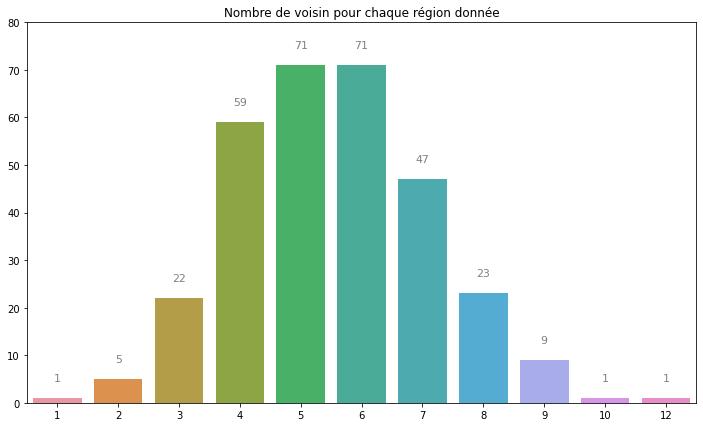

In [81]:
gdf = medianhousing.copy()
# add NEIGHBORS column
gdf["NEIGHBORS"] = None  
gdf["NBR_NEIGHBORS"] = None

for index, country in gdf.iterrows():   

    neighbors = gdf[~gdf.geometry.disjoint(country.geometry)].NAME.tolist() # Get des communes qui sont NON disjoints
    neighbors = [ name for name in neighbors if country.NAME != name ] # # remove own name of the country from the list
   
    gdf.at[index, "NEIGHBORS"] = ", ".join(neighbors)  # add names of neighbors as NEIGHBORS value
    gdf.at[index, "NBR_NEIGHBORS"] = len(neighbors)  # add len of neighbors as NEIGHBORS value
print(gdf.loc[:,"NBR_NEIGHBORS"].head(3))

print("")
plt.figure(figsize=(12,7))
ax = sns.barplot(x=gdf.NBR_NEIGHBORS.value_counts().index, y=gdf.NBR_NEIGHBORS.value_counts().values, )

#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                 textcoords='offset points')
_ = ax.set_ylim(0,80)
ax.set_title("Nombre de voisin pour chaque région donnée")

**Reponse:** 5 et 6 ont plus de voisins

#### Q: What is the smallest number of neighbors? How many tracts have that number of neighbors?
**Réponse:** 1 est le plus petit nbre de voisin

#### Q: Where do tracts with a small number of neighbors tend to be located?

Text(0.5, 1.0, 'Localisation des parcelles ayant un petit nombre de voisins')

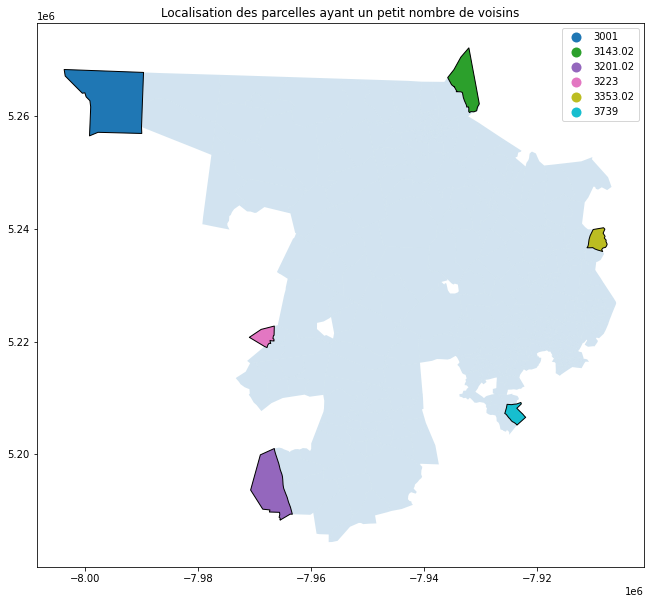

In [84]:
ax = gdf.plot(figsize=(15,10), alpha=0.2,)
gdf[gdf['NBR_NEIGHBORS']<=2].plot(figsize=(13,7), column="NAME", edgecolor="k", ax=ax,legend=True)
ax.set_title("Localisation des parcelles ayant un petit nombre de voisins")

#### Visiblement il se trouvent aux de la carte.

## Univariate Moran’s I (Global statistic)  
Le I de Moran est un test d'autocorrélation globale pour un attribut continu :Le I de Moran est un test d'autocorrélation globale pour un attribut continu :

### Q: What is the I value? What does this mean?

In [99]:
# Nous pouvons utiliser le package esda de PySAL pour effectuer l'analyse :
import esda 
from splot.esda import plot_moran

np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.639785528675383

Là encore, notre valeur pour la statistique doit être interprétée par rapport à une référence distribution sous la nullité de la RSE. PySAL utilise une approche de permutations spatiales aléatoires. `999 Permutations`

### Q: Do there appear to be more clusters or outliers?

<Figure size 936x432 with 0 Axes>

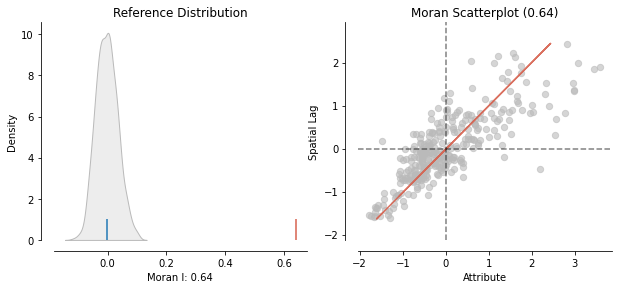

In [103]:

plot_moran(mi, zstandard=True, figsize=(10,4), )
plt.show()

Les données réelles en `bleu` vs ce que les données synthétiques de PySAL en `rouge`. Ceci montre un structe hautement autocorréllée et donc notre valeur observée `0.639785528675383` est statistiquement significative.  

Comme dansl'analyses réaliser avec `GEODA` on aussi un aspect `cluster`car on a plus de points dans la zone `haute droite(HH` et``base gauche(LL`.

## Univariate Local Moran’s I

In [ ]:
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import lisa_cluster

In [107]:
np.random.seed(12345)

In [108]:
medianhousing_rook.transform = 'r'
lag_price = lp.weights.lag_spatial(medianhousing_rook, gdf['Median_val'])

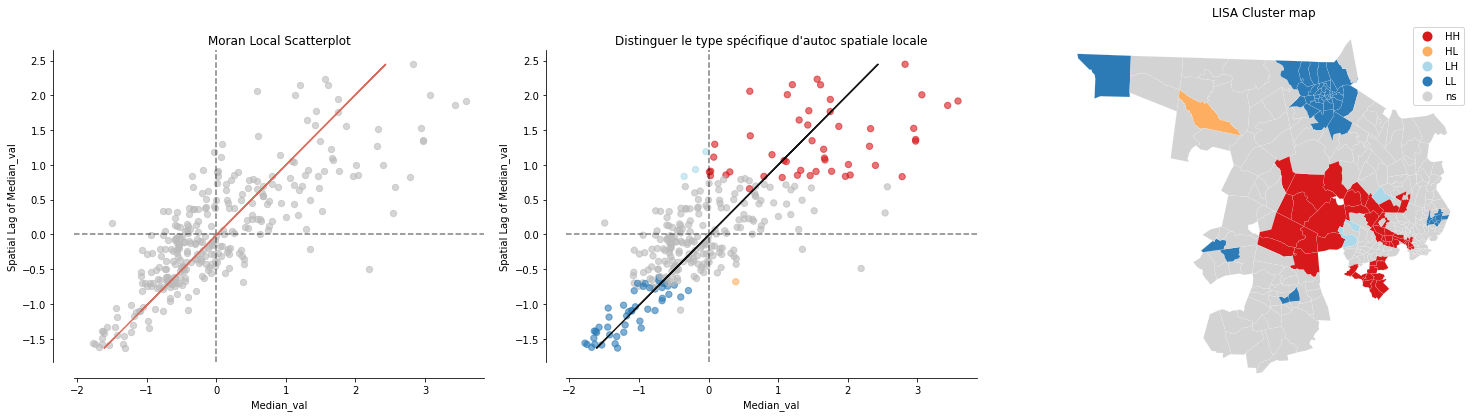

In [137]:
fig, ax = plt.subplots(1,3, figsize=(25,12), subplot_kw=dict(aspect="equal"))

# calculate Moran_Local and plot
moran_loc = Moran_Local(y, medianhousing_rook)
moran_scatterplot(moran_loc, ax=ax[0])
ax[0].set_xlabel('Median_val')
ax[0].set_ylabel('Spatial Lag of Median_val')
#
moran_scatterplot(moran_loc, p=0.05, ax=ax[1])
ax[1].set_title("Distinguer le type spécifique d'autoc spatiale locale")
ax[1].set_xlabel('Median_val')
ax[1].set_ylabel('Spatial Lag of Median_val')

lisa_cluster(moran_loc, gdf, p=0.05, figsize = (9,9), ax=ax[2])
ax[2].set_title('LISA Cluster map')
plt.show()

### Q: Where are the clusters on your map? Where are the outliers?
